# Problem Statement:

### To explore classical time series modeling on time series data (4.	https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

In [3]:
df_comed = pd.read_csv("resources/COMED_hourly.csv")

In [4]:
df_comed = df_comed.sort_values(by='Datetime').reset_index().drop(columns=['index'])

In [5]:
df_comed.dtypes

Datetime     object
COMED_MW    float64
dtype: object

In [6]:
df_comed['Datetime'] = pd.to_datetime(df_comed['Datetime'])

In [7]:
df_comed.dtypes

Datetime    datetime64[ns]
COMED_MW           float64
dtype: object

In [8]:
df_comed.head()

,Datetime,COMED_MW
0,2011-01-01 01:00:00,9631.0
1,2011-01-01 02:00:00,9273.0
2,2011-01-01 03:00:00,9011.0
3,2011-01-01 04:00:00,8741.0
4,2011-01-01 05:00:00,8694.0


In [9]:
df_comed.shape

(66497, 2)

In [10]:
df_comed = df_comed.drop_duplicates()

In [11]:
df_comed.shape

(66497, 2)

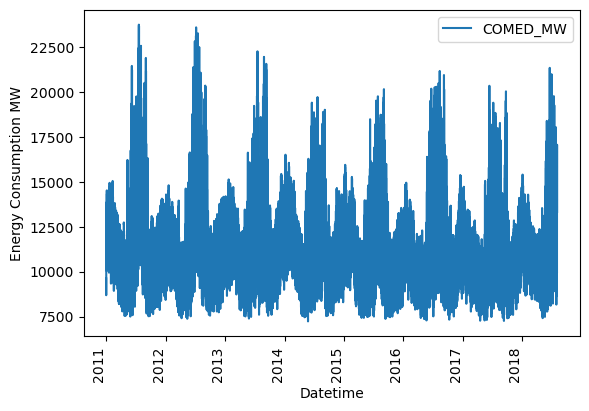

In [12]:
df_comed.plot(x='Datetime', y='COMED_MW')
plt.xticks(rotation=90)
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption MW')
plt.show()

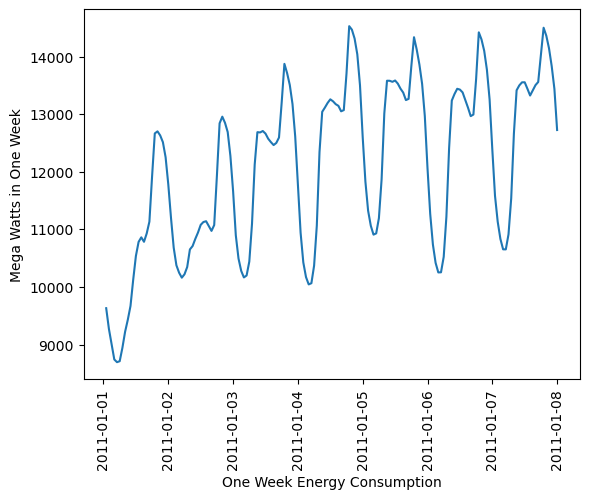

In [16]:
plt.plot(df_comed.Datetime[:(7*24)], df_comed['COMED_MW'][:(7*24)])
plt.xticks(rotation = 90)
plt.xlabel('One Week Energy Consumption')
plt.ylabel('Mega Watts in One Week')
plt.show()

In [22]:
# Creating some extra features.
def create_features(df):
    df['Date'] = df['Datetime']
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['DayOfMonth'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.weekofyear
    df['DayOfYearFloat'] = df['DayOfYear'] + df['Hour'] / 24
    df.drop('Date', axis=1, inplace=True)
    return df

df_comed = create_features(df_comed)

C:\Users\ma6114132\AppData\Local\Temp\ipykernel_5472\3141569287.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['WeekOfYear'] = df['Date'].dt.weekofyear


In [24]:
df_comed.head()

,Datetime,COMED_MW,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
0,2011-01-01 01:00:00,9631.0,1,5,1,1,2011,1,1,52,1.041667
1,2011-01-01 02:00:00,9273.0,2,5,1,1,2011,1,1,52,1.083333
2,2011-01-01 03:00:00,9011.0,3,5,1,1,2011,1,1,52,1.125000
3,2011-01-01 04:00:00,8741.0,4,5,1,1,2011,1,1,52,1.166667
4,2011-01-01 05:00:00,8694.0,5,5,1,1,2011,1,1,52,1.208333


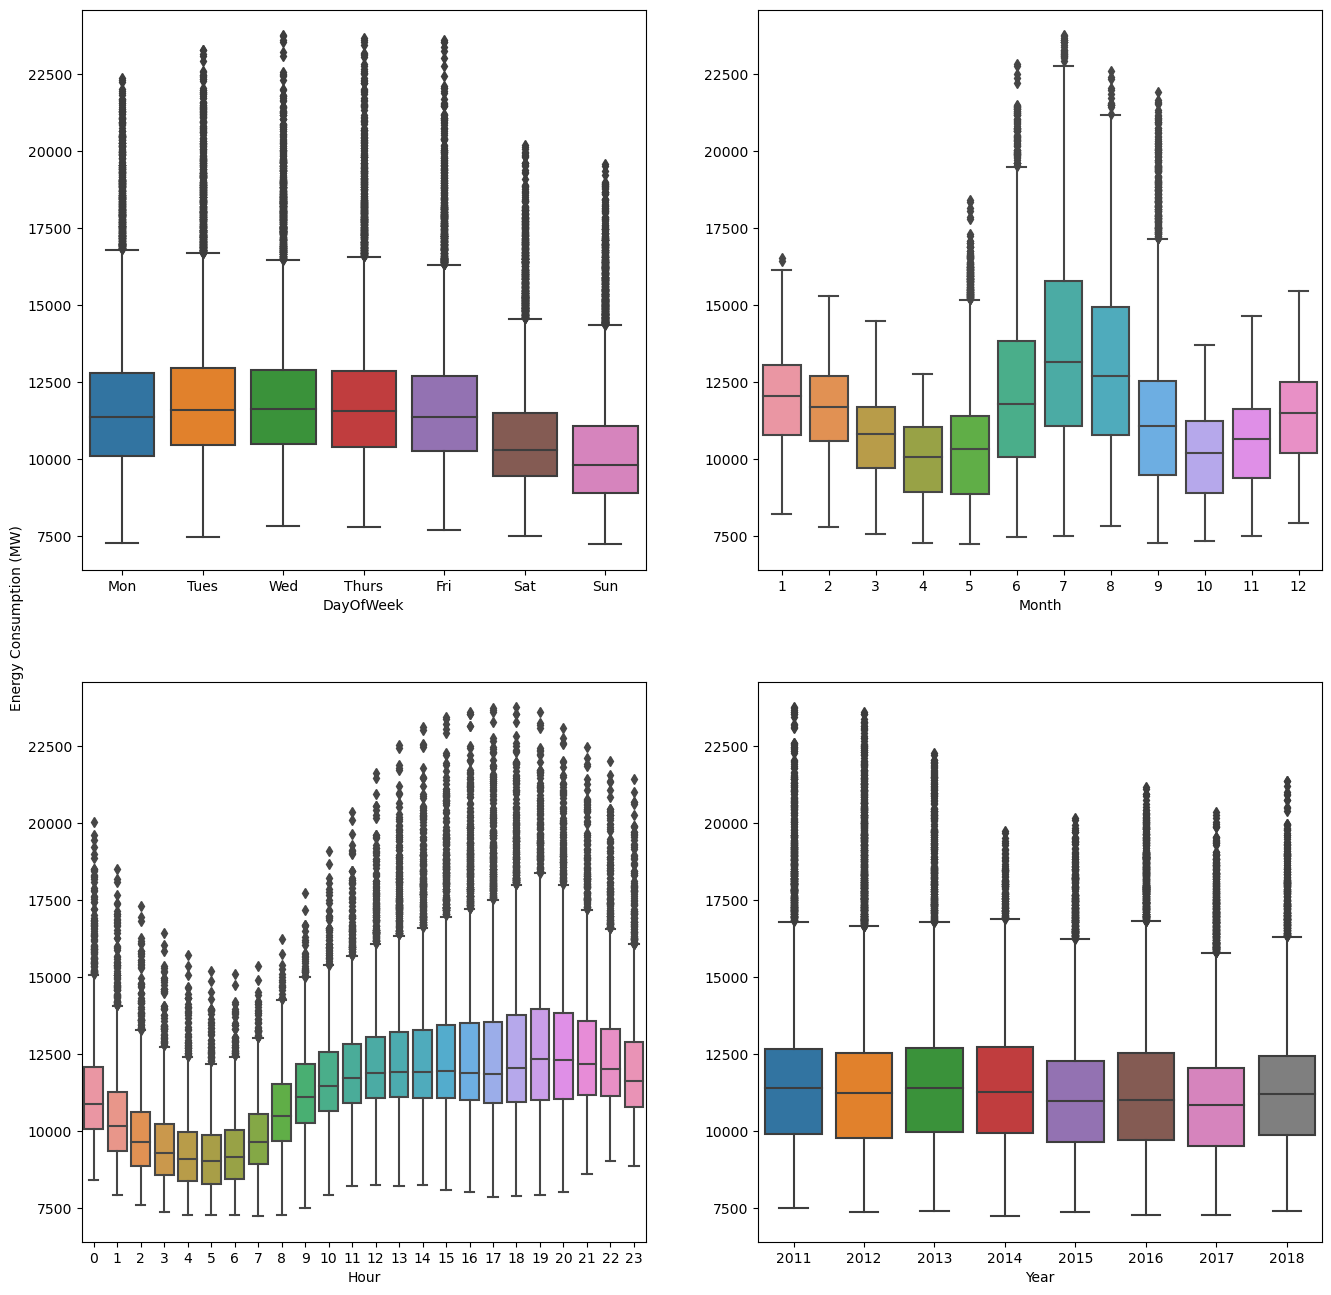

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(16,16))

# Day of Week
dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
g = sns.boxplot(x=df_comed.DayOfWeek, y=df_comed.COMED_MW, ax=axes[0][0])
g.set_xticklabels(dow_labels)
g.set_ylabel('')

# Month of Year
g = sns.boxplot(x=df_comed.Month, y=df_comed.COMED_MW, ax=axes[0][1])
g.set_ylabel('')

# Hour of Day
g = sns.boxplot(x=df_comed.Hour, y=df_comed.COMED_MW, ax=axes[1][0])
g.set_ylabel('')

# Year
g = sns.boxplot(x=df_comed.Year, y=df_comed.COMED_MW, ax=axes[1][1])
g.set_ylabel('')
fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
plt.savefig('boxplots.png')
plt.show()

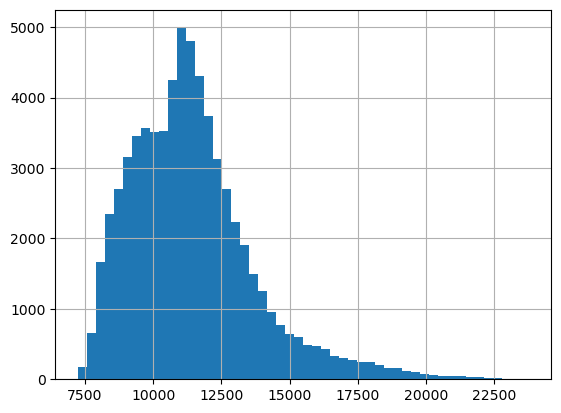

In [27]:
data_series = df_comed['COMED_MW']
data_series.hist(bins=50)
plt.savefig('histogram.png')
plt.show()

Now let's plot the seasonal plot per year

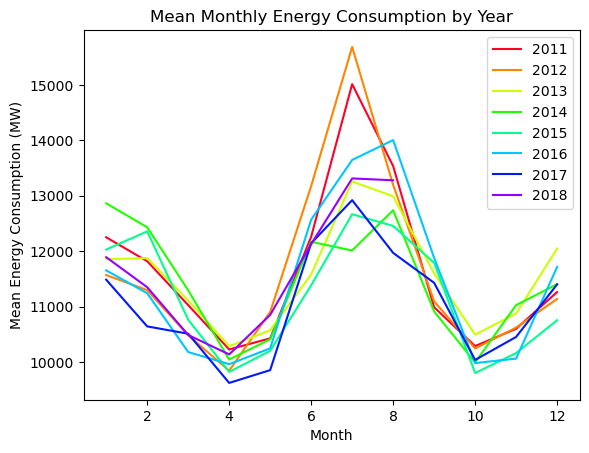

In [33]:
year_group = df_comed.groupby(['Year', 'Month']).mean().reset_index()
years = df_comed['Year'].unique()
NUM_COLORS = len(years)

cm = plt.get_cmap('gist_rainbow')
# print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i, y in enumerate(years):
    df = year_group[year_group['Year'] == y]
    #rolling_mean = df.DUQ_MW.rolling(window=7*24).mean()
    plt.plot(df['Month'], df['COMED_MW'])
plt.title('Mean Monthly Energy Consumption by Year')
plt.xlabel('Month')
plt.ylabel('Mean Energy Consumption (MW)')
plt.legend(df_comed.Year.unique())
plt.savefig('seasonal_plot.png')
plt.show()

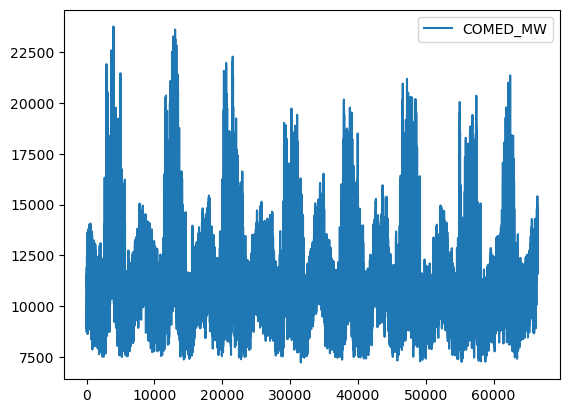

In [32]:
df_comed.plot()
plt.show()

In [6]:
df_comed.isnull().sum()

Datetime    0
COMED_MW    0
dtype: int64

So there are no missing values

In [7]:
# Getting the length and taking the samle of the data to 
# calculate the mean and variance of sample data (This is the first way to check for stationarity)

time_series_len = df_comed.shape[0]
sample_legth = time_series_len // 3
part_1, part_2, part_3 = df_comed['COMED_MW'][0:sample_legth], df_comed['COMED_MW'][(sample_legth):(2*sample_legth)], df_comed['COMED_MW'][(2*sample_legth):(3*sample_legth)]
print("the mean of samples are ", part_1.mean(), part_2.mean(), part_3.mean())
print("the variance of samples are ",part_1.var(), part_2.var(), part_3.var())

the mean of samples are  11690.207759981953 11288.859553349876 11281.239612000902
the variance of samples are  6572132.688425587 4017743.361206887 5228535.912940826


Looks like the data is not stationary. Let's apply ADF test.

In [48]:
# ADF Test
result = adfuller(df_comed['COMED_MW'], autolag='AIC')

In [49]:
# 1. ADF Test Statistic
# 2. p-value
# 3. lags
result

(-14.831166977457908,
 1.89830079869459e-27,
 61,
 66435,
 {'1%': -3.430448435353142,
  '5%': -2.861583506641688,
  '10%': -2.5667931571051694},
 829654.0349328336)

p-value is greater than 5% (-2.86158). Therefore null hypothesis cannot be rejected (i.e. data is non stationary)

In [17]:
x=df_comed['COMED_MW']
x[0]

9970.0

<Figure size 640x480 with 0 Axes>

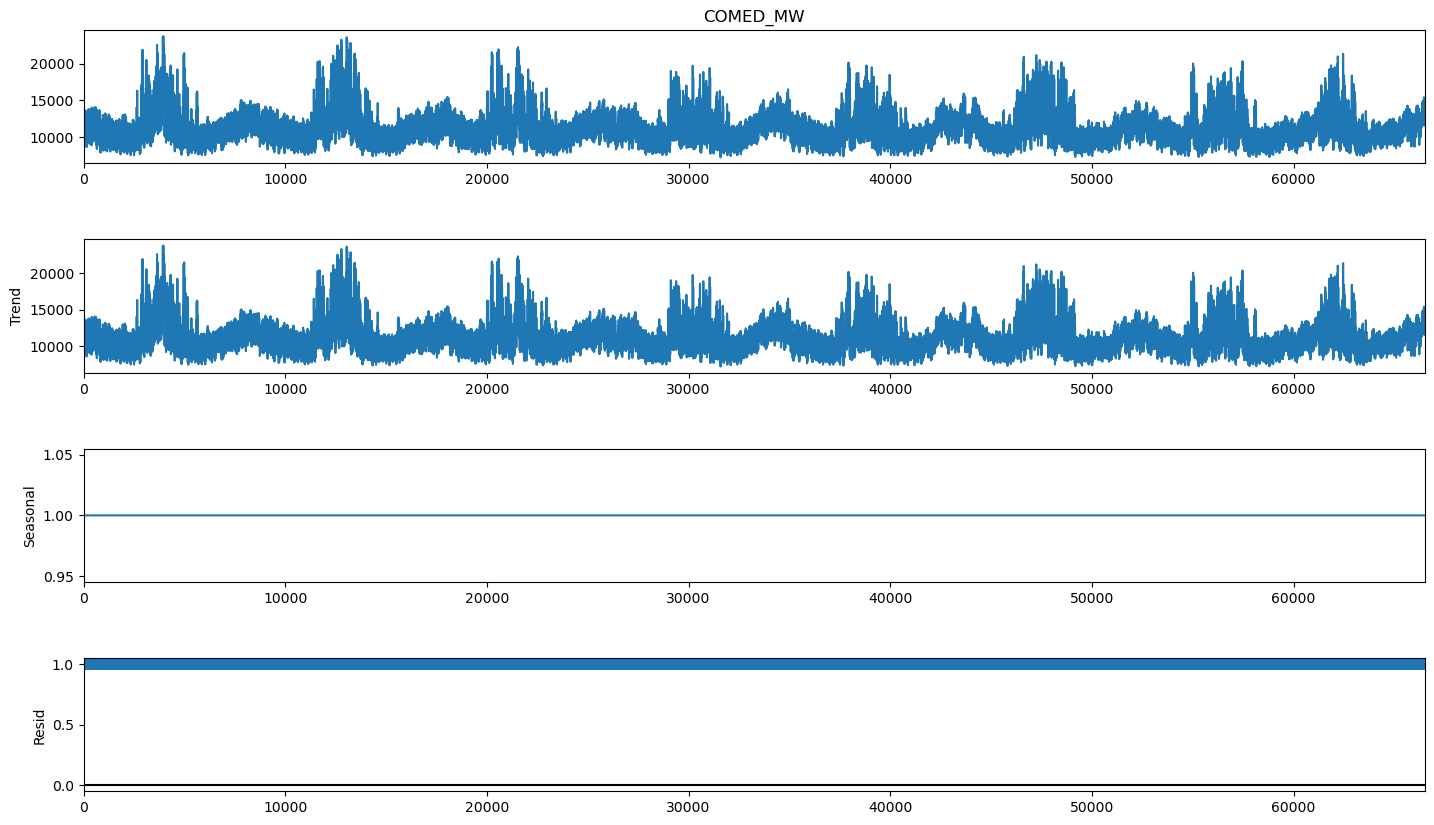

In [20]:
result = seasonal_decompose(x, model='multiplicative',period=1)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [21]:
df_comed_log = np.log(df_comed['COMED_MW'])

In [24]:
result_log = seasonal_decompose(df_comed_log, model='multiplicative', period=1)

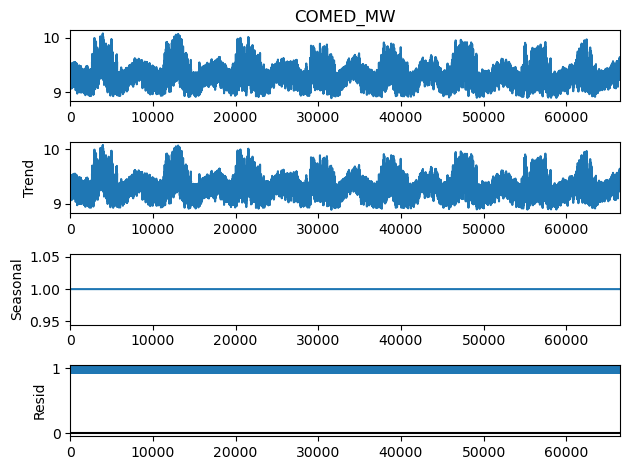

In [25]:
result_log.plot()
plt.show()

In [50]:
diff = []
for i in range(1, len(df_comed_log)):
    diff.append((df_comed_log[i] - (df_comed_log[i-1])))

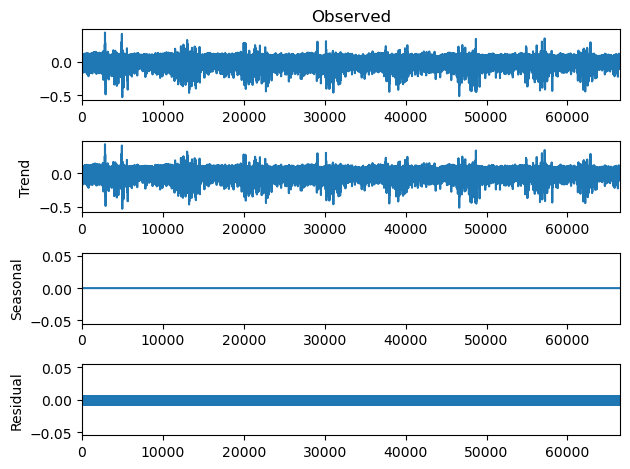

In [51]:
result_log_diff = seasonal_decompose(diff, model='additive', period=1)
result_log_diff.plot()
plt.show()

In [52]:
result_diff = adfuller(diff, autolag='AIC')

In [54]:
result_diff

(-39.05478603478699,
 0.0,
 61,
 66434,
 {'1%': -3.430448436834901,
  '5%': -2.861583507296588,
  '10%': -2.566793157453752},
 -307847.5257662324)